In [1]:
import numpy as np
import pandas as pd
from src.prepare_dataset import prepare_data
from utils import data_wrapper
from utils.metrics import regression_report
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import joblib
import matplotlib.pyplot as plt
import random

In [2]:
prepare_data("data/final_dataset_aggregated.csv", "prep_data", scale_method = "min_max")

2024-08-01 13:27:40.021 | INFO     | src.prepare_dataset:prepare_data:17 - Args:  data/final_dataset_aggregated.csv ; prep_data ; 0.7 ; 0.1 ; min_max


data/final_dataset_aggregated.csv


2024-08-01 13:27:40.269 | INFO     | src.prepare_dataset:prepare_data:33 - Dropped the unnecessary columns
2024-08-01 13:27:40.270 | INFO     | src.prepare_dataset:prepare_data:38 - Dataset size BEFORE dropping the rows by date: 28299
2024-08-01 13:27:40.328 | INFO     | src.prepare_dataset:prepare_data:40 - Dataset size AFTER dropping the rows by date: 28026
2024-08-01 13:27:40.363 | INFO     | src.prepare_dataset:prepare_data:57 - Overall encoded 5 cateforical features
2024-08-01 13:27:40.363 | INFO     | src.prepare_dataset:prepare_data:58 - ['power_on', 'break_time', 'school_hours', 'school_day', 'classroom_type']
2024-08-01 13:27:40.363 | INFO     | src.prepare_dataset:prepare_data:60 - Removing the `measured_t_*` columns, except : measured_t_mean
2024-08-01 13:27:40.398 | INFO     | src.prepare_dataset:prepare_data:84 - Filled the missing values of variables
2024-08-01 13:27:40.400 | INFO     | src.prepare_dataset:prepare_data:87 - Dropped tmstamp column
2024-08-01 13:27:40.402 |

In [3]:
train = pd.read_csv("prep_data/train.csv")
val = pd.read_csv("prep_data/valid.csv")
test = pd.read_csv("prep_data/test.csv")

In [4]:
train.head()

,classroom_type,measured_t_mean,school_day,school_hours,break_time,power_on,trackerwm_avg_mean,shadowwm_avg_mean,sunwm_avg_mean,shadowbandwm_avg_mean,...,rh_mean,ws_ms_s_wvt_mean,winddir_d1_wvt_mean,winddir_sd1_wvt_mean,bp_mb_avg_mean,uva_avg_mean,uvb_avg_mean,Month,Day,Hour
0,0,0.647059,1,0,0,1,0.011026,0.120501,0.020462,0.045077,...,0.785270,0.028474,0.022461,0.032420,0.099109,0.008539,0.093667,3,16,7
1,1,0.638739,1,0,0,1,0.011313,0.145285,0.024634,0.054065,...,0.784698,0.020416,0.014059,0.032387,0.099379,0.008752,0.093545,3,16,7
2,2,0.679674,1,0,0,1,0.033126,0.180489,0.032191,0.066739,...,0.778259,0.071458,0.049206,0.113354,0.100912,0.008796,0.093511,3,16,7
3,4,0.578334,1,0,0,1,0.001889,0.152176,0.025020,0.056610,...,0.792080,0.042610,0.017301,0.060713,0.099583,0.009259,0.093511,3,16,7
4,0,0.690157,1,1,0,1,0.464367,0.192743,0.090702,0.071083,...,0.642038,0.015844,0.110935,0.054132,0.107573,0.008796,0.093511,3,16,8


In [5]:
def rearrange(data):
    features = data.drop(['measured_t_mean'], axis=1)
    target = data['measured_t_mean']
    combined = pd.concat([features, target], axis=1)
    return combined

In [6]:
train = rearrange(train)
val = rearrange(val)
test = rearrange(test)

In [7]:
train.head()

,classroom_type,school_day,school_hours,break_time,power_on,trackerwm_avg_mean,shadowwm_avg_mean,sunwm_avg_mean,shadowbandwm_avg_mean,dnicalc_avg_mean,...,ws_ms_s_wvt_mean,winddir_d1_wvt_mean,winddir_sd1_wvt_mean,bp_mb_avg_mean,uva_avg_mean,uvb_avg_mean,Month,Day,Hour,measured_t_mean
0,0,1,0,0,1,0.011026,0.120501,0.020462,0.045077,0.017824,...,0.028474,0.022461,0.032420,0.099109,0.008539,0.093667,3,16,7,0.647059
1,1,1,0,0,1,0.011313,0.145285,0.024634,0.054065,0.012926,...,0.020416,0.014059,0.032387,0.099379,0.008752,0.093545,3,16,7,0.638739
2,2,1,0,0,1,0.033126,0.180489,0.032191,0.066739,0.021338,...,0.071458,0.049206,0.113354,0.100912,0.008796,0.093511,3,16,7,0.679674
3,4,1,0,0,1,0.001889,0.152176,0.025020,0.056610,0.008966,...,0.042610,0.017301,0.060713,0.099583,0.009259,0.093511,3,16,7,0.578334
4,0,1,1,0,1,0.464367,0.192743,0.090702,0.071083,0.243491,...,0.015844,0.110935,0.054132,0.107573,0.008796,0.093511,3,16,8,0.690157


In [8]:
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data)-seq_length):
        x = data.iloc[i:(i+seq_length), :-1].values
        y = data.iloc[i+seq_length, -1]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [9]:
seq_length = 6
X_train, y_train = create_sequences(train, seq_length)
X_test, y_test = create_sequences(test, seq_length)
X_val, y_val = create_sequences(val, seq_length)

In [10]:
(np.isnan(X_test) == True).sum()

0

In [11]:
# Prepare data for evaluation
device = torch.device('cpu')
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

In [12]:
# Set the seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## RNN

In [13]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

In [14]:
# Hyperparameters list
input_size = X_train.shape[2]
hidden_sizes = [100, 200]
num_layers_list = [1, 2]
output_size = 1
num_epochs = 40
batch_sizes = [32, 64]
learning_rates = [0.001, 0.0001]
best_val_loss = float('inf')
best_hyperparams = None
train_losses_dict = {}
val_losses_dict = {}

In [15]:
# Model training with hyperparameter tuning
for batch_size in batch_sizes:    
    for hidden_size in hidden_sizes:
        for num_layers in num_layers_list:
            for learning_rate in learning_rates:
                print(f'Training with batch_size={batch_size}, hidden_size={hidden_size}, num_layers={num_layers}, learning_rate={learning_rate}')

                # Initialize the model, loss function, and optimizer
                model = RNN(input_size, hidden_size, num_layers, output_size).to(device)
                criterion = nn.MSELoss()  
                optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

                # Create DataLoader for training data
                train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
                train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

                # Lists to store training and validation losses
                train_losses = []
                val_losses = []

                # Training loop with validation
                for epoch in range(num_epochs):
                    model.train()
                    epoch_train_loss = 0
                    for inputs, labels in train_loader:
                        inputs, labels = inputs.to(device), labels.to(device)
                        outputs = model(inputs)
                        loss = criterion(outputs, labels.unsqueeze(1))

                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                        epoch_train_loss += loss.item()

                    avg_train_loss = epoch_train_loss / len(train_loader)
                    train_losses.append(avg_train_loss)

                    # Validation
                    model.eval()
                    with torch.no_grad():
                        val_outputs = model(X_val_tensor)
                        val_loss = criterion(val_outputs, y_val_tensor.unsqueeze(1)).item()
                        val_losses.append(val_loss)

                    if (epoch+1) % 2 == 0:
                        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {val_loss:.4f}')

                # Store the training and validation losses
                train_losses_dict[(batch_size, hidden_size, num_layers, learning_rate)] = train_losses
                val_losses_dict[(batch_size, hidden_size, num_layers, learning_rate)] = val_losses

                # Check if the current model has the best validation loss
                if val_losses[-1] < best_val_loss:
                    best_val_loss = val_losses[-1]
                    best_hyperparams = (batch_size, hidden_size, num_layers, learning_rate)
                    best_model = model

print(f'Best Hyperparameters: {best_hyperparams} with Validation Loss: {best_val_loss:.4f}')


Training with batch_size=32, hidden_size=100, num_layers=1, learning_rate=0.001
Epoch [2/40], Training Loss: 0.0108, Validation Loss: 0.0448
Epoch [4/40], Training Loss: 0.0102, Validation Loss: 0.0217
Epoch [6/40], Training Loss: 0.0092, Validation Loss: 0.0169
Epoch [8/40], Training Loss: 0.0087, Validation Loss: 0.0155
Epoch [10/40], Training Loss: 0.0087, Validation Loss: 0.0169
Epoch [12/40], Training Loss: 0.0086, Validation Loss: 0.0155
Epoch [14/40], Training Loss: 0.0085, Validation Loss: 0.0171
Epoch [16/40], Training Loss: 0.0082, Validation Loss: 0.0173
Epoch [18/40], Training Loss: 0.0080, Validation Loss: 0.0174
Epoch [20/40], Training Loss: 0.0079, Validation Loss: 0.0285
Epoch [22/40], Training Loss: 0.0078, Validation Loss: 0.0237
Epoch [24/40], Training Loss: 0.0076, Validation Loss: 0.0278
Epoch [26/40], Training Loss: 0.0076, Validation Loss: 0.0273
Epoch [28/40], Training Loss: 0.0069, Validation Loss: 0.0245
Epoch [30/40], Training Loss: 0.0070, Validation Loss: 0

Epoch [10/40], Training Loss: 0.0095, Validation Loss: 0.0064
Epoch [12/40], Training Loss: 0.0091, Validation Loss: 0.0050
Epoch [14/40], Training Loss: 0.0097, Validation Loss: 0.0068
Epoch [16/40], Training Loss: 0.0089, Validation Loss: 0.0089
Epoch [18/40], Training Loss: 0.0105, Validation Loss: 0.0075
Epoch [20/40], Training Loss: 0.0101, Validation Loss: 0.0097
Epoch [22/40], Training Loss: 0.0101, Validation Loss: 0.0075
Epoch [24/40], Training Loss: 0.0100, Validation Loss: 0.0080
Epoch [26/40], Training Loss: 0.0095, Validation Loss: 0.0070
Epoch [28/40], Training Loss: 0.0094, Validation Loss: 0.0064
Epoch [30/40], Training Loss: 0.0094, Validation Loss: 0.0072
Epoch [32/40], Training Loss: 0.0095, Validation Loss: 0.0091
Epoch [34/40], Training Loss: 0.0094, Validation Loss: 0.0059
Epoch [36/40], Training Loss: 0.0091, Validation Loss: 0.0076
Epoch [38/40], Training Loss: 0.0090, Validation Loss: 0.0059
Epoch [40/40], Training Loss: 0.0091, Validation Loss: 0.0067
Training

Epoch [20/40], Training Loss: 0.0084, Validation Loss: 0.0061
Epoch [22/40], Training Loss: 0.0080, Validation Loss: 0.0078
Epoch [24/40], Training Loss: 0.0074, Validation Loss: 0.0082
Epoch [26/40], Training Loss: 0.0079, Validation Loss: 0.0088
Epoch [28/40], Training Loss: 0.0073, Validation Loss: 0.0071
Epoch [30/40], Training Loss: 0.0077, Validation Loss: 0.0066
Epoch [32/40], Training Loss: 0.0071, Validation Loss: 0.0072
Epoch [34/40], Training Loss: 0.0071, Validation Loss: 0.0109
Epoch [36/40], Training Loss: 0.0069, Validation Loss: 0.0135
Epoch [38/40], Training Loss: 0.0067, Validation Loss: 0.0194
Epoch [40/40], Training Loss: 0.0061, Validation Loss: 0.0131
Training with batch_size=64, hidden_size=200, num_layers=1, learning_rate=0.0001
Epoch [2/40], Training Loss: 0.0176, Validation Loss: 0.0450
Epoch [4/40], Training Loss: 0.0111, Validation Loss: 0.0344
Epoch [6/40], Training Loss: 0.0095, Validation Loss: 0.0282
Epoch [8/40], Training Loss: 0.0085, Validation Loss: 

In [16]:
# Save model
torch.save(best_model.state_dict(), "rnn.pt")

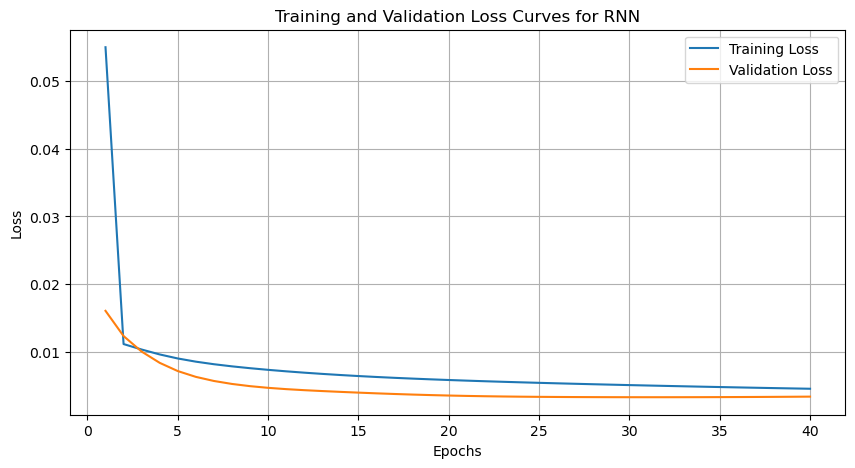

In [17]:
# Plot the loss curves for the best hyperparameters for RNN
best_train_losses = train_losses_dict[best_hyperparams]
best_val_losses = val_losses_dict[best_hyperparams]

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), best_train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), best_val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves for RNN')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
# Evaluate on test set
with torch.no_grad():
    test_outputs = best_model(X_test_tensor)
    test_predictions = test_outputs.cpu().numpy()
    test_targets = y_test_tensor.cpu().numpy()

In [19]:
# Rescale predictions and targets
scaler =joblib.load("prep_data/assets/min_max_scaler_y.joblib",mmap_mode=None)
test_predictions_rescaled = scaler.inverse_transform(test_predictions)
test_targets_rescaled = scaler.inverse_transform(test_targets.reshape(-1, 1))

In [20]:
results_df = pd.DataFrame({
    'true': test_targets_rescaled.flatten(),
    'pred': test_predictions_rescaled.flatten()
})
results_df.to_csv('rnn_preds.csv', index=False)

In [21]:
regression_report(test_targets, test_predictions)

{'Mean Absolute Error (MAE)': 0.15676739811897278,
 'Mean Squared Error (MSE)': 0.032144226133823395,
 'Root Mean Squared Error (RMSE)': 0.1792881041765213,
 'Mean Absolute Percentage Error (MAPE)': 0.25038963556289673,
 'R2 Score': -0.9875650357754191}

Text(0, 0.5, 'Indoor Temperature')

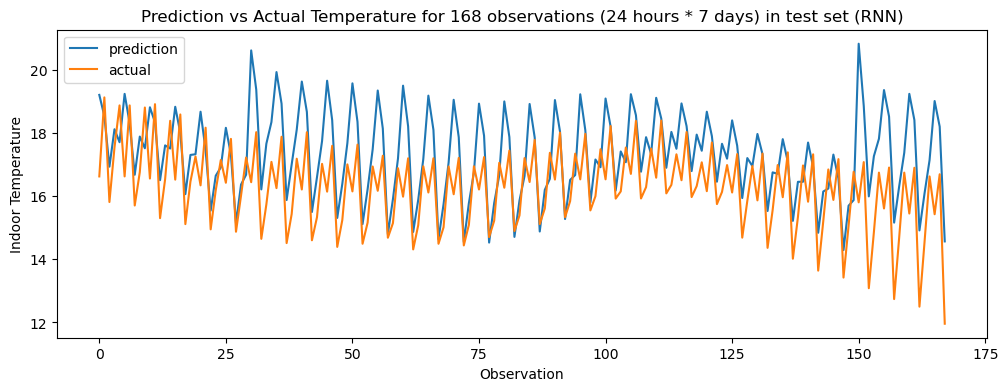

In [22]:
plt.figure(figsize=(12, 4))
plt.plot(test_predictions_rescaled[:168])
plt.plot(test_targets_rescaled[:168])
plt.legend(['prediction', 'actual'], loc='upper left')
plt.title(f'Prediction vs Actual Temperature for 168 observations (24 hours * 7 days) in test set (RNN)')
plt.xlabel('Observation')
plt.ylabel('Indoor Temperature')

## RNN - CNN

In [23]:
class RNN_CNN_Model(nn.Module):
    def __init__(self, input_size, rnn_hidden_size, rnn_num_layers, cnn_out_channels, cnn_kernel_size, output_size):
        super(RNN_CNN_Model, self).__init__()
        self.rnn = nn.RNN(input_size, rnn_hidden_size, rnn_num_layers, batch_first=True)
        self.conv = nn.Conv1d(in_channels=rnn_hidden_size, out_channels=cnn_out_channels, kernel_size=cnn_kernel_size)
        self.fc = nn.Linear(cnn_out_channels * (seq_length - cnn_kernel_size + 1), output_size)
    
    def forward(self, x):
        # x shape: (batch_size, seq_length, input_size)
        h0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size).to(x.device)
        rnn_out, _ = self.rnn(x, h0)  # rnn_out: (batch_size, seq_length, rnn_hidden_size)
        
        # Convolution expects input as (batch_size, in_channels, seq_length)
        cnn_in = rnn_out.permute(0, 2, 1)  # cnn_in: (batch_size, rnn_hidden_size, seq_length)
        cnn_out = F.relu(self.conv(cnn_in))  # cnn_out: (batch_size, cnn_out_channels, new_seq_length)
        
        # Flatten the output for the fully connected layer
        cnn_out = cnn_out.view(cnn_out.size(0), -1)
        output = self.fc(cnn_out)  # Final output
        return output

In [24]:
# Hyperparameters
input_size = X_train.shape[2]
rnn_hidden_size = 50
rnn_num_layers = 1
cnn_out_channels = 16
cnn_kernel_size = 3
output_size = 1
num_epochs = 30
batch_size = 32
learning_rate = 0.001

In [25]:
# Model training

# Prepare data loaders
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device('cpu')
model = RNN_CNN_Model(input_size, rnn_hidden_size, rnn_num_layers, cnn_out_channels, cnn_kernel_size, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop with validation
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    epoch_train_loss = 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels.unsqueeze(1))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_train_loss += loss.item()
    
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    model.eval()
    epoch_val_loss = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels.unsqueeze(1))
            epoch_val_loss += loss.item()
    
    avg_val_loss = epoch_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    if (epoch+1) % 2 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}')


Epoch [2/30], Training Loss: 0.0111, Validation Loss: 0.0168
Epoch [4/30], Training Loss: 0.0093, Validation Loss: 0.0140
Epoch [6/30], Training Loss: 0.0081, Validation Loss: 0.0169
Epoch [8/30], Training Loss: 0.0082, Validation Loss: 0.0083
Epoch [10/30], Training Loss: 0.0072, Validation Loss: 0.0057
Epoch [12/30], Training Loss: 0.0068, Validation Loss: 0.0056
Epoch [14/30], Training Loss: 0.0066, Validation Loss: 0.0052
Epoch [16/30], Training Loss: 0.0065, Validation Loss: 0.0048
Epoch [18/30], Training Loss: 0.0062, Validation Loss: 0.0057
Epoch [20/30], Training Loss: 0.0060, Validation Loss: 0.0052
Epoch [22/30], Training Loss: 0.0058, Validation Loss: 0.0038
Epoch [24/30], Training Loss: 0.0056, Validation Loss: 0.0039
Epoch [26/30], Training Loss: 0.0054, Validation Loss: 0.0039
Epoch [28/30], Training Loss: 0.0053, Validation Loss: 0.0039
Epoch [30/30], Training Loss: 0.0050, Validation Loss: 0.0033


In [26]:
# Save model
torch.save(model.state_dict(), "rnn_cnn.pt")

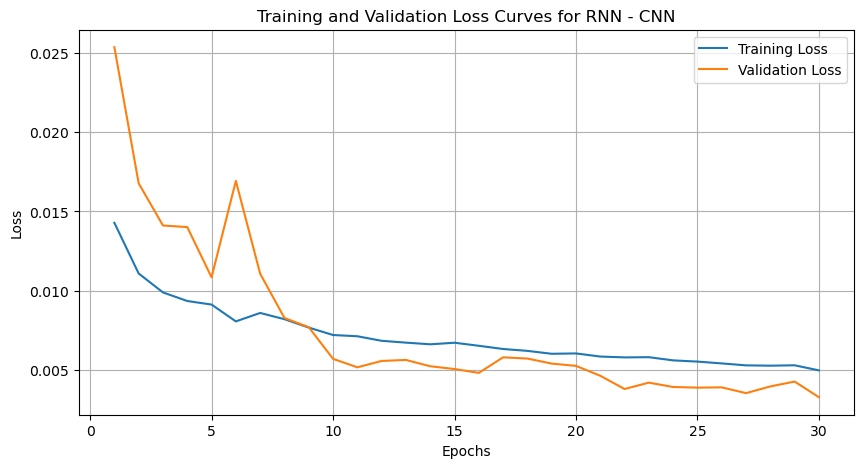

In [27]:
# Plot the loss curves for RNN - CNN
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Curves for RNN - CNN')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
# Evaluate on test set
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    test_predictions = test_outputs.cpu().numpy()
    test_targets = y_test_tensor.cpu().numpy()

In [29]:
# Rescale predictions and targets
scaler =joblib.load("prep_data/assets/min_max_scaler_y.joblib",mmap_mode=None)
test_predictions_rescaled = scaler.inverse_transform(test_predictions)
test_targets_rescaled = scaler.inverse_transform(test_targets.reshape(-1, 1))

In [30]:
results_df = pd.DataFrame({
    'true': test_targets_rescaled.flatten(),
    'pred': test_predictions_rescaled.flatten()
})
results_df.to_csv('rnn_cnn_preds.csv', index=False)

In [31]:
regression_report(test_targets, test_predictions)

{'Mean Absolute Error (MAE)': 0.15599480271339417,
 'Mean Squared Error (MSE)': 0.032587889581918716,
 'Root Mean Squared Error (RMSE)': 0.180521160364151,
 'Mean Absolute Percentage Error (MAPE)': 0.2500859200954437,
 'R2 Score': -1.014998297067383}

Text(0, 0.5, 'Indoor Temperature')

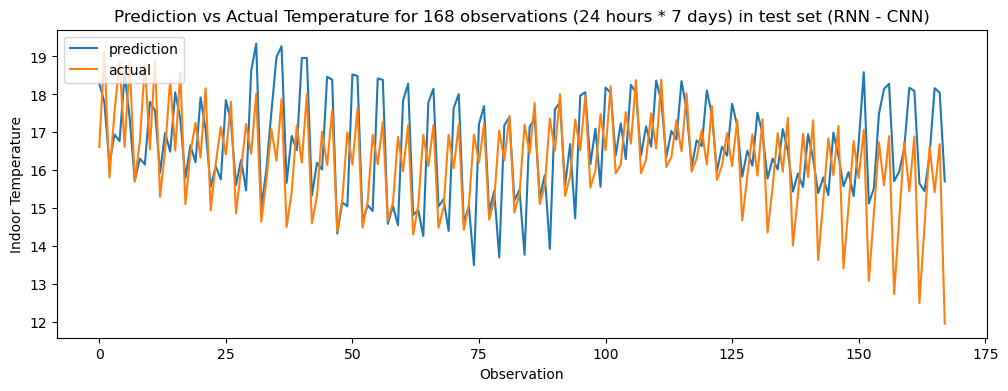

In [32]:
plt.figure(figsize=(12, 4))
plt.plot(test_predictions_rescaled[:168])
plt.plot(test_targets_rescaled[:168])
plt.legend(['prediction', 'actual'], loc='upper left')
plt.title(f'Prediction vs Actual Temperature for 168 observations (24 hours * 7 days) in test set (RNN - CNN)')
plt.xlabel('Observation')
plt.ylabel('Indoor Temperature')